In [7]:
import sys
sys.path.append('../projects/pyscf/')

In [8]:
from pyscf import gto, scf, mcscf, fci
from pyscf.fci import cistring
import openfermion as of
import cirq
from openfermion.circuits import trotter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

## Application Instance: Bulk Synthesis of Cyclic Ozone Rocket Fuel Oxidizing Agent 

The existence of the cyclic form of ozone has long been predicted but has yet to be synthesized. In 2014, a method for synthesizing ozone within carbon fullerene cages as patented [1]. While the intention of this patent was to develop a UV light absorbing agent, the methods they put forward could allow for the synthesis of cyclic ozone [2]. In free space, cyclic ozone is a meta-stable minimum atomic configuration on ozone's ground state potential energy surface as shown below (this figure is adapted from [3]).

<img src="cyclic_ozone_landscape.png" width ="45%" height="45%">

The idea is to find the fullerene cage(s) $C_n$ for $n > 60$ that lowers the energy of the ring minimum below the open minimum. Density functional theory calculations suggest that, while cyclic ozone is slightly more stable when encapsulated within $C_{60}$, bent ozone is still more stable than cyclic ozone overall within $C_{60}$ [2]. A large selection for possible carbon fullerenes and their molecular geometries can be downloaded at https://nanotube.msu.edu/fullerene/fullerene-isomers.html. Bent ozone encapsulated in $C_{60}$ is shown below (this figure is adapted from [1]).

<img src="encapsulated_ozone.png" width ="35%" height="35%">

The relative stability of cyclic ozone to bent ozone is primarily captured by **thermodynamic stability** which is calculated as $\Delta E_{thermo}(n) = E_0(O_3(D_{3h}) @ C_n) - E_0(O_3(C_{2v}) @ C_n)$ where $E_0(X)$ is the ground state of molecule $X$, $O_3(D_{3h})$ and $O_3(C_{2v})$ are cyclic and bent ozone respectively, and $X @ C_n$ denotes a chemical $X$ encapsulated in the fullerene $C_n$. Note that we can further generalize to more than one ozone molecule and instead consider combinations of various proportions of cyclic and bent ozone. If $\Delta E_{thermo}(n) < 0$, then cyclic ozone is more stable than bent ozone when encapsulated in $C_n$.

### In this notebook, 
we will consider the first computational challenge for quantum hardware on the road to computing $\Delta E_{thermo}(n)$: compute the ground state of cyclic ozone $E_0(O_3(D_{3h}))$. A nice feature of this computational challenge is that we can check the result against classical computations which provide us with precise estimates of the ground state energy as well as information about the resource requirements required to implement quantum phase estimation (QPE) for computing $E_0(O_3(D_{3h}))$ to chemical accuracy $1.6$ mHa.

We begin by computing the ground state energy of cyclic ozone for various zeta orbital basis sets cc-pV$x$Z where $x=2,3,4,5$. The electronic structure of ozone is quite complex and hence require careful treatment. One approach would be to calculate the entire FCI wavefunction for the molecule, however this is cumbersome and would lead to unnecessarily complex quantum circuits. Instead we take a note from a thorough study of ozone's electronic structure [4] and restrict our calculations to an active space $n_{electrons} = 18$, $n_{orbitals} = 12$. We note that choosing an appropriate active space is likely a necessary step when attempting quantum chemical calculations on quantum computers given the great difference in resource requirements e.g., the full space for ozone would require $180$ qubits while the active space only requires $24$ qubits!

In [11]:
# Compute geometry of cyclic ozone
molecule = gto.Mole()

bond_len = 1.465  # Angstroms
bond_angle = np.deg2rad(59.9)

x = bond_len * np.sin(bond_angle / 2)
y = bond_len * np.cos(bond_angle / 2)

o3_geometry = [('O', (x, -y / 2, 0)),
               ('O',(-x, -y / 2, 0)),
               ('O', (0, y / 2, 0))]

molecule.atom = o3_geometry
molecule.basis = 'ccpvtz'
molecule.charge = 0
molecule.symmetry = True
molecule.build()

molecule.spin

0

In [283]:
# Compute the ground state energy of cyclic ozone for various zeta basis sets
bases = ['ccpvdz', 'ccpvtz', 'ccpvqz', 'ccpv5z']
es_basis_sets = [] # Store a list of resulting ground state energies

for base in bases:
    molecule = gto.Mole()

    # Compute geometry of cyclic ozone
    bond_len = 1.465  # Angstroms
    bond_angle = np.deg2rad(59.9)

    x = bond_len * np.sin(bond_angle / 2)
    y = bond_len * np.cos(bond_angle / 2)

    o3_geometry = [('O', (x, -y / 2, 0)),
                   ('O',(-x, -y / 2, 0)),
                   ('O', (0, y / 2, 0))]

    molecule.atom = o3_geometry
    molecule.basis = base
    molecule.charge = 0
    molecule.symmetry = True
    molecule.build()

    # Compute the ROHF wavefunction
    mf = scf.ROHF(molecule).run()

    # Compute the CASSCF wavefunction
    norb = 12   # number of orbitals to correlate
    nelec = 18  # number of electrons
    mc = mcscf.CASSCF(mf, norb, nelec)
    mc.fcisolver = fci.direct_spin1.FCI(molecule)
    e = mc.kernel()
    es_basis_sets.append(e[0])

converged SCF energy = -224.242514851918
CASSCF energy = -224.456349372434
CASCI E = -224.456349372434  E(CI) = -86.2402172027521  S^2 = 0.0000000
converged SCF energy = -224.318811930198
CASSCF energy = -224.529665396463
CASCI E = -224.529665396463  E(CI) = -86.3125513821444  S^2 = 0.0000000
converged SCF energy = -224.33506598158
CASSCF energy = -224.545880118128
CASCI E = -224.545880118128  E(CI) = -86.3243301353626  S^2 = 0.0000000
converged SCF energy = -224.33946656736
CASSCF energy = -224.550280717867
CASCI E = -224.550280717867  E(CI) = -86.325805715945  S^2 = 0.0000000


Note that as we compute ground state energies for larger zeta basis sets, the energies start to converge to a true ground state energy. We can use this data to extrapolate to the infinite basis set limit and obtain an estimate for the true ground state energy. This extrapolation involves fitting a curve to the data $\{ (x, E_0(x)) \}_{x=2}^5$ where $E_0(x)$ is the ground state energy obtained with basis set cc-pV$x$Z. The extrapolation function we choose for this exercise is $E_0(x) = B + Ax^{-3}$ where $B = E_0(\infty)$. 

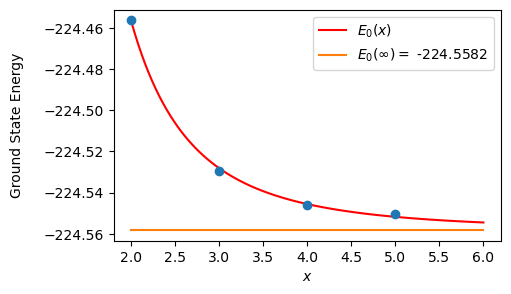

In [368]:
def E0(x, a, b): # Define extrapolation function
    return b + a*x**-3

xs = [2., 3., 4., 5.] # Basis set sizes

popt, pcov = curve_fit(E0, xs, es_basis_sets) # Fit CBS curve

# Get points along fitted curve
ydata = []
xdata = np.linspace(2,6,100)
for x in xdata:
    ydata.append(E0(x, popt[0], popt[1]))

E0_inf = popt[1]
    
# Plot data
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(xdata, ydata, 'r-', label='$E_0(x)$')
ax.plot(xs, es_basis_sets, 'o')
ax.plot(xdata, [E0_inf for i in range(len(xdata))], label='$E_0(\infty) =$ ' + str(np.round(E0_inf, 4)))

ax.set_xlabel('$x$')
ax.set_ylabel('Ground State Energy', labelpad=14)
plt.legend()
plt.show()

In order to use resource estimation tools based on OpenFermion, such as **pyLIQTR** from MIT, we can use the PySCF module in OpenFermion to generate the fermionic 2nd quantization molecular Hamiltonian for the electrons in cyclic ozone. Once we run this calculation, we will save the data to a ```.hdf5``` file. Note that for larger molecules, it may be preferable to use the standalone PySCF library to generate the Hamiltonian data using more substantial compute resources e.g., a cluster.

In [190]:
### 
### Define the molecule and generate the Hamiltonian
### using openfermion and openfermionpyscf tools
###
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

description = 'O3'

geometry = o3_geometry
basis = 'ccpvtz'
charge = 0
multiplicity = 1

molecule = MolecularData(geometry, basis, multiplicity, charge, description, filename='o3_molecule')

###
### Use this command to calculate the 1e and 2e values.
###
molecule = run_pyscf(molecule,
    run_scf=1,
    run_mp2=0,
    run_cisd=0,
    run_ccsd=0,
    run_fci=0,
     verbose=0)

###
### Save the molecule to the file
### specified above
###
molecule.save()

We now demonstrate how to load the file and construct an active space. The active space is configured according to the appropriate active space suggested in [4] for the ozone molecule $CAS(18,12)$.

In [513]:
file_name = 'o3_molecule.hdf5'

molecule = of.MolecularData(filename=file_name)
molecule.load()

# Get the Hamiltonian in an active space.
active_space_start = 3
active_space_stop = 15
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

print(f'Hartree-Fock Energy   = {molecule.hf_energy}')

Hartree-Fock Energy   = -224.3188119301983


In order to demonstrate the process of resource estimation, we look at quantum simulation algorithm that was designed to efficiently time evolve fermionic systems [arXiv:1808.02625](https://arxiv.org/abs/1808.02625). Note newer methods exist that further improve the runtime of this algorithm [arXiv:2011.03494](https://arxiv.org/abs/2011.03494).

There are two primary ways in which quantum computers can approximate the unitary operator $U(t) = \exp(-iHt)$. The first is **quantum signal process** and the second is **Trotter-Suzuki products**. For a given quantum simulation/dynamics task, evaluating which of these two techniques is better is an important step in determining a resource efficient quantum algorithm. The algorithm proposed in [arXiv:1808.02625](https://arxiv.org/abs/1808.02625) is the latter type of algorithm. Remarkably, this method has formulas for exact gate count for Clifford + T gate sets.

Let $N_{orb} = N_{occ} + N_{vir}$ be the number of **spin orbitals** of a given molecule where $N_{occ}, N_{vir}$ are the number of occupied and virtual spin orbitals. In the case of the $CAS(18,12)$ active space for cyclic ozone, $N_{orb} = 24$. Let $L$ be the precision parameters *rank*. For a linear nearest neighbor architecture and a gate set using $CX$ or $CZ$ as the entangling gate, the Trotter method at hand requires a number of quantum gates (operations) given by the formula
$N_{gates} = 3 \times \left[ \sum_{\ell=1}^L \frac{N \rho_\ell}{4} + \frac{\rho_\ell^2}{4} - \rho_\ell \right ]$
with circuit depth of $N_{depth} = \sum_{\ell = 1}^L \frac{N}{2} + \frac{3\rho_\ell}{2}$. The parameter $\rho_\ell$ is a more subtle algorithm parameter that scales in expected value as $O(N_{orb})$ for some molecules and $O(\log( N_{orb}))$ for others. The critical precision parameter is rank $L$, for the exact decomposition of time evolution operator we require $L = N_{orb}^2$ and $\rho_\ell = N_{orb}$.

For a Clifford + T gateset, we can calculate the number of $T$ gates required to approximate all single qubit rotations in the quantum algorithm to an error of $\epsilon_{synth}$ as $N_T = (2.3 \log(1/\epsilon_{synth})) \sum_{\ell=1}^L \frac{N \rho_\ell}{2} - 2 \rho_\ell$. Note that there is another algorithmic parameter of Trotter-Suzuki methods known as Trotter step number $n_{step}$. These resource estimates are for $n_{step} = 1$, however, often we take $n_{step} > 1$ to get higher fidelity quantum simulations.

In [544]:
def T_gatecount(eps, N, rhos):
    count = 0
    for rho in rhos:
        count += N*rho/2 - 2*rho
    
    count *= 2.3 * np.log(1/eps)
    return int(np.ceil(count))

def circuit_depth(N, rhos):
    count = 0
    for rho in rhos:
        count += N*rho/2 + 3*rho/2
        
    return int(np.ceil(count))

In order to estimate ground state energies on quantum computers, we typically need to use quantum phase estimation and so the error we require from the output of QPE is influenced by three main error sources within the algorithm. The first is Trotter-Suzuki error $\epsilon_{TS}$, or more generally quantum simulation error. This is the error in the eigenvalues of the approximate $U(t)$ to the true eigenvalues. The second source of error is the synthesis error $\epsilon_{synth}$  when using $T$ gate approximations to single qubit rotations in the quantum circuit. The last source of error comes from QPE $\epsilon_{QPE}$. An example of an error target for chemical problems is $\epsilon_{tot} \leq 0.1$mHa where $\epsilon_{tot} = \epsilon_{TS} + \sqrt{\epsilon_{QPE}^2 + \epsilon_{synth}^2}$. This total error formula was proposed in [arXiv:1605.03590](https://arxiv.org/abs/1605.03590). Note that $0.1$ mHa is a high accuracy requirement, often "chemical accuracy" is considered to be $1.6$ mHa.

To provide an example of a resource estimate, let's take a full rank $L = N_{orb}^2$ decomposition of the time evolution operator and assume we have negligible $\epsilon_{TS}$. We can parameter sets, which we will discuss later in this notebook, to achieve $0.1$mHa we can take $\epsilon_{QPE} = \epsilon_{synth} = 0.07$ mHa. This provides us with the T gate count for one step of the Trotter simulation.

In [543]:
eps_synth = 0.00007
print("T gate count estimate: " + str(T_gatecount(eps_synth, 24, [24 for i in range(24**2)])))

T gate count estimate: 3041852


In [545]:
print("Circuit Depth: " + str(circuit_depth(24, [24 for i in range(24**2)])))

Circuit Depth: 186624


Note that [arXiv:1808.02625](https://arxiv.org/abs/1808.02625) found chemically accurate Hamiltonian Trotter steps for a 50 qubit molecular simulation with 4,000 layers of parallel nearest-neighbor two-qubit gates, consisting of fewer than $10^5$ non-Clifford rotations which is substantially fewer required resources than the above example.

OpenFermion has a few Trotter algorithms built-in, specifically the algorithm from [arXiv:1808.02625](https://arxiv.org/abs/1808.02625). We can set some basic parameters such as the rank $L$. Furthermore, we generate the controlled version of the time evolution operator $CU(t)$. This is the type of circuit used in quantum phase estimation and hence the gate count from this computation has inform us about the overall cost of QPE. The default in Cirq is for number of Trotter steps $n_{step}= 1$, however performing the quantum simulation accurately often means taking a higher number of Trotter steps. For this exercise, we consider $n_{steps} = 10$.

In [562]:
from time import perf_counter

tic = perf_counter()
time = 1. # Circuit for approximating U = exp(-iH)
# Trotter step parameters.
final_rank = 24 # 24 spin orbitals in cyclic ozone active space
n_steps = 10

# Initialize circuit qubits in a line.
n_qubits = of.count_qubits(molecular_hamiltonian)
qubits = cirq.LineQubit.range(n_qubits+1)

# Compile the low rank Trotter step using OpenFermion.
custom_algorithm = trotter.LowRankTrotterAlgorithm(final_rank=final_rank)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits[1:], molecular_hamiltonian,
            time=time, n_steps = n_steps,
            algorithm=custom_algorithm,
     control_qubit = qubits[0]),
    strategy=cirq.InsertStrategy.EARLIEST)

cirq.drop_negligible_operations(circuit)

toc = perf_counter()

print("Circuit compile time: " + str(toc-tic)+" seconds")

Circuit compile time: 25.566087935003452 seconds


Cirq allows for the compilation of the above Trotter method to a $CZ$-based gate set. We can evaluate the depth of the resulting circuit and use it to compare against other methods for quantum simulation and quantum compilation.

**Running the below cells can take a long time!!!**

In [578]:
tic = perf_counter()
gateset = cirq.CZTargetGateset(allow_partial_czs=False)
cz_circuit = cirq.optimize_for_target_gateset(circuit, gateset=gateset)
toc = perf_counter()

print("Circuit compile time (to CZ gate set): " + str(toc-tic)+" seconds")

Circuit compile time (to CZ gate set): 13070.47286646199 seconds


In [579]:
depth = len(cirq.Circuit(cz_circuit.all_operations()))
print("Circuit Depth: "+str(depth))

Circuit Depth: 951668


In [606]:
"""
    Get single and two qubit gates
"""
single_qubit_gates = 0
cz_gates = 0

for ops in cz_circuit.all_operations():
    
    if isinstance(ops.gate, cirq.PhasedXZGate):
        single_qubit_gates += 1
    
    else:
        cz_gates += 1
        
print("Single qubit gate count: " + str(single_qubit_gates))
print("CZ gate count: " + str(cz_gates))

Single qubit gate count: 1857619
CZ gate count: 735344


We can use the work of Li [arXiv:2111.10430](https://arxiv.org/abs/2111.10430) to compute lower bounds for the ancilla required for traditional QPE for computing the ground state of cyclic ozone to an error $\leq 2^{-n}$ for some $n \geq 1$.

Let $|\psi_{0}\rangle$ be the approximate ground state we use for the initial state in the QPE algorithm e.g., the Hartree-Fock state. Then, there is some value $a$ such that $|| H|\psi_0\rangle - a |\psi_0\rangle || < \delta$ where $H$ is the molecular Hamiltonian. Now define the energy gap $\Delta E = \min_{\lambda \not = E_0} |a-\lambda|$ where $E_0$ is the ground state and $\lambda$ is another eigenvalue of $H$ i.e., the spectral gap. It turns out that we can relate this quantity to the overlap between the initial state and the true ground state as follows $|\langle \psi_0 | \psi_{true} \rangle|^2 \geq 1 - \frac{\delta^2}{\Delta E^2}$. Theorem 2.2 in the work of Li states that the number of ancilla qubits $n_{anc}$ required for QPE to gaurentee as probability of success of $1-\epsilon$ is bounded below by

$n_{anc} \geq n + \log(2+\delta^2/2\epsilon\Delta E^2) \geq n + \log(2+(1-|\langle \psi_0 | \psi_{true} \rangle|^2)/2\epsilon)$

Here we have $n$ as the number of qubits needed to achieve error $\leq 2^{-n}$ and $|\langle \psi_0 | \psi_{true} \rangle|^2 = 0.862$ in the case of cyclic ozone. If we wish to achieve $\epsilon_{QPE} = 0.00007$, then we need to take $n=13$ We now calculate the ancilla requirements for QPE based on desired probabiliy of success.

Note that [arXiv:2111.10430](https://arxiv.org/abs/2111.10430) also provides a lower bound for the number of required Trotter steps $n_{step} \geq \frac{\exp(n-n_{anc}/2p)}{\Delta E^{1/p}\epsilon^{1/2p}}$ when using a $2p$-th order product formula.

In [576]:
overlap = mc.ci[0,0]**2 # = 0.862, this is the overlap between the CASSCF wavefunction and the Hartree-Fock state
n = 13

eps = [0.5, 0.1, 0.01, 0.001]
for e in eps:
    tbound = n + np.log(2 + ((1-overlap)/(2*e)))
    print('Probability of Success = ' + str(1-e) + ', n_anc >= ' + str(tbound))

Prob. of Success = 0.5, t >= 13.75968277677811
Prob. of Success = 0.9, t >= 13.988793734412782
Prob. of Success = 0.99, t >= 15.183790392535599
Prob. of Success = 0.999, t >= 17.259844997787134


If we are using traditional quantum phase estimation, then the overall circuit will consist of first Hadamards on the ancilla qubits $H^{\otimes n_{anc}} |0\rangle_{ancilla}$ and the preparation of the approximate eigenstate on the primary register such as the Hartree-Fock state. The preparation of the Hartree-Fock state is not difficult and thus we restrict our attention to the subsequent controlled unitaries $CU(t)^{2^{k-1}}$ for $k=1$ to $k=n_{anc}$ and quantum Fourier Transform (QFT). If we are compiling to a Clifford + T gate set, then we can construct a logarithimic depth approximate QFT using the methods of [arXiv:1803.04933](https://arxiv.org/abs/1803.04933) which requires $O(n_{anc} \log n_{anc})$ $T$ gates and has a circuit depth bounded above by $O(\log n_{anc} + \log\log1/\epsilon_{QFT})$ where $\epsilon_{QFT}$ is the QFT error parameter. 


If we choose instead to use iterative phase estimation, then we get rid of the QFT entirely and only have to keep track of the cost of implementing $CU(t)^{2^{k-1}}$. Therefore, one aspect of pulling off QPE is evaluating what is the most efficient way to construct $CU(t)^{2^{k-1}}$ for various $k \geq 1$. The below is a figure adapted from [5] which depicts the iterative phase estimation circuit.

<img src="iterative_pe.png" width ="45%" height="45%">

In order to find the right circuit and algorithm for a given problem, it is effective to compile circuits for many different variations on quantum phase estimation that each use a different method for implementing $CU(t)^{2^{k-1}}$. 
 
The [T-Fermion](https://arxiv.org/abs/2110.05899) library was used to compute T gate counts for various QPE implementations. Below is a graph of the resulting T gate counts, adapted from [arXiv: 2110.05899](https://arxiv.org/abs/2110.05899).
 
<img src="tgate_count.png" width ="45%" height="45%">

We observe that the sparcity low-rank method out-perform all other methods over several molecules. In this way T gate count can also quantify the "complexity" of a chemical system e.g. $H_2$ has lower T gate count because it is a simple molecule whereas complex molecules like FeMoCo require substantially more T gates. The results from T-Fermion suggest that the sparcity low-rank method, proposed in [arXiv:1902.02134](https://arxiv.org/abs/1902.02134), is the best choice for small molecules so it represents a good candidate for the final resource estimate for a standalone cyclic ozone molecule.

Another approach to encode quantum chemical simulation Hamiltonians is to use the Jordon-Wigner transform (or other candidate transfroms such as Bravyi-Kitaev) to convert 2nd quantization fermionic Hamiltonians into spin Hamiltonians. We can generate the Jordon-Wigner transformed molecular Hamiltonian using OpenFermion:

In [569]:
from openfermion import jordan_wigner

H_jw = jordan_wigner(molecular_hamiltonian)
print(H_jw)

-208.67770105644811 [] +
-0.03213457679337885 [X0 X1 Y2 Y3] +
-7.193498651304138e-06 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Y9] +
-0.00673816791088792 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
0.013915596891696334 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 Z18 Z19 Z20 Y21] +
-7.193498651304139e-06 [X0 X1 X3 Z4 Z5 Z6 Z7 X8] +
-0.00673816791088792 [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
0.013915596891696334 [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 Z18 Z19 X20] +
-0.03211341492467843 [X0 X1 Y4 Y5] +
-0.0066599568464906595 [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Y13] +
0.00012143722572122612 [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 Z18 Y19] +
0.013960479419725832 [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 Z18 Z19 Z20 Z21 Z22 Y23] +
-0.0066599568464906595 [X0 X1 X5 Z6 Z7 Z8 Z9 Z10 Z11 X12] +
0.0001214372257212261 [X0 X1 X5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 X18] +
0.013960479419725834 [X0 X1 X5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z1

In [608]:
pstring = []
count = 0
for ops in H_jw:
    pstring.append(str(ops))
    count +=1
print(count)

7881


In [4]:
pstr  = np.load('o3_jw_H.npy')

In [5]:
pstr

array(['-208.67770105644811 []', '2.181151639270091 [Z0]',
       '2.181151639270091 [Z1]', ...,
       '0.008712642649247591 [X20 Y21 Y22 X23]',
       '0.008712642649247591 [Y20 X21 X22 Y23]',
       '-0.008712642649247591 [Y20 Y21 X22 X23]'], dtype='<U110')

In [6]:
float('-203')

-203.0

In [610]:
np.save('o3_jw_H.npy', np.array(pstring))

## References

[1] S. Naseri, M. Bock, Endohedral fullerenes having enclosed therein one or more ozone molecules, and their use as a UV-absorbing agent, US8623337 B2, 2014. <http://www.google.com.ar/patents/US8623337>

[2] Denis Sh. Sabirov, Igor S. Shepelevich,
Information entropy of oxygen allotropes. A still open discussion about the closed form of ozone,
Computational and Theoretical Chemistry, Volume 1073, 2015, Pages 61-66, ISSN 2210-271X, https://doi.org/10.1016/j.comptc.2015.09.016.

[3] Chien, A. D., Holmes, A. A., Otten, M., Umrigar, C. J., Sharma, S., & Zimmerman, P. M. (2018). Excited States of Methylene, Polyenes, and Ozone from Heat-Bath Configuration Interaction. In The Journal of Physical Chemistry A (Vol. 122, Issue 10, pp. 2714–2722). American Chemical Society (ACS). https://doi.org/10.1021/acs.jpca.8b01554

[4] Theis, D., Ivanic, J., Windus, T. L., & Ruedenberg, K. (2016). The transition from the open minimum to the ring minimum on the ground state and on the lowest excited state of like symmetry in ozone: A configuration interaction study. In The Journal of Chemical Physics (Vol. 144, Issue 10, p. 104304). AIP Publishing. https://doi.org/10.1063/1.4942019

[5] Dobšíček, M., Johansson, G., Shumeiko, V., & Wendin, G. (2007). Arbitrary accuracy iterative quantum phase estimation algorithm using a single ancillary qubit: A two-qubit benchmark. Physical Review A, 76, 030306.

[6] Berry, D. W., Gidney, C., Motta, M., McClean, J. R., & Babbush, R. (2019). Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization. In Quantum (Vol. 3, p. 208). https://doi.org/10.22331/q-2019-12-02-208